<a href="https://colab.research.google.com/github/Cleaverj/Protoplanetary_Disk_Research/blob/main/SED_GUIDE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Hi!

My name is Jacob and I was a previous student working with Prof. Hartmann. Our work primarily dealt with modeling outburst events from protoplanetary disks and as part of that I had to create SED's for each disk model we made. In this notebook I go through how to calculate/plot the SED's from the disks, a star, and a more thourough model with the disk + star as well as factoring in extinction caused by interstellar dust. Im not certain how useful every part will be for you but I hope it will atleast be a good starting point!

## Necessary Starting Stuff and Things

I did most of my research in google colab. This is a really nice platform as you can connect it to your google drive. However, there is a runtime, so colab will time out after a certain amount of time has passed. If you end up needing to do calculations with a longer runtime then I would recommend using a Jupyter Notebook

This cell connects the google notebook to drive. I found this to be a useful tool as it allowed things to be easily shared between myself and prof. Hartmann without the need for email or downloads. You may need to change the path to this notebook depending on where you have the folder containing the files loacted. Additionally, the notebook can be ran in Jupyter notebook as well, you will just need to remove the following cell and change the paths to match your system but it should work. By defing the variable 'base' here we can shorten all the paths we will be referencing for the rest of the notebook

In [196]:
from google.colab import drive
drive.mount('/content/drive/')

base = '/content/drive/MyDrive/SED GUIDE HARTMANN UNDERGRAD/'

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


Below I load in the necessary libraries as well define some constants. I dont use all the constants but it is nice to have them predefined in case you do need them later.

In [197]:
pip install spectres

In [198]:
pip install PyAstronomy

In [199]:
import numpy as np
from spectres import spectres
import os
import matplotlib.pyplot as plt
import pickle
from PyAstronomy import pyasl

In [200]:
c = 3E10 #* u.centimeter/ u.second
c_A = 3E18 #A/s
h = 6.62E-27 #*u.erg *u.second
kb = 1.38E-16 #* u.erg / u.Kelvin
kpc = 3.0857E21 #cm
stefboltz = 5.6705E-5 #erg*cm^-2*sec^-1*K^-4

## SED of a Protoplanetary Disk

To start with I have loaded in the 7 models we used in our paper into a folder entitled 'SED FILES'

The files containing the disk SED's are compiled using a function called pickle. I used pickle so I could maintain the array shape in which I have a large array with each time step of the disks evolution in it and within each timestep there is a SED saved as well. To load in the pickled document you can use pickle.load() as shown below. This function will output the luminosity SED in erg/s/Angstrom of the disk for each timestep in an array as well as the corresponding wavelengths in Angstrom.

In [201]:
def load_lum(filename):
    total_file = base + 'SED FILES/' + str(filename) + '.txt'
    with open(total_file, 'rb') as f:
        my_lists = pickle.load(f)
    wav = np.arange(3.20e-05, 8.00e-04, 1e-7) * (1e8)
    return wav, np.array(my_lists)

The next function converts the disk luminosity spectrum into flux by setting it at a given distance (preset to a kpc but can be changed if specified when the function is called) and giving it an inclination (avg. inclination is cosi = 1/2 so this is the preset amount). One note is that distance should be in cm so that the final flux is in erg/cm^2/s/Angstrom

In [202]:
def flux(lum, distance = kpc, cosi = .5):
  return cosi * (lum/(2*np.pi*(distance**2)))

Now we can try loading in one of the disk files. In this case it is mar.6.1 and as seen by the print statement there were 111 timesteps in this model

In [203]:
wav1, lum1 = load_lum('mar.6.1')
print(len(lum1))

111


We can plot this luminosity vs wavelength for a specific timestep (dump 40 for example). P.S. if you havent used .savefig before it is a lifesaver. the figure can be save as .eps or .jpg or whatever you might like. I spent a year taking screenshots of my results before realizing I could save them so if I can save you from making the same mistake I will.

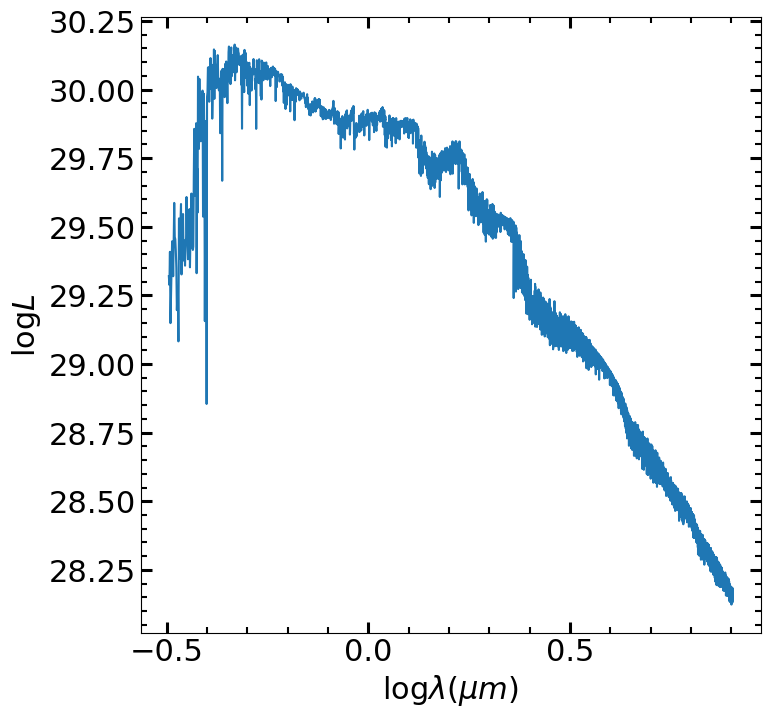

In [204]:
fig = plt.figure(figsize = (8, 8))
plt.rc('font', size=22)
plt.plot(np.log10(wav1 * (1e-4)), np.log10(lum1[40]))
plt.ylabel('log' +  f'$L$')
plt.xlabel('log' +  f'$\lambda (\mu m)$')
plt.minorticks_on()
plt.tick_params(which = 'major', right = True, top = True, direction = 'in', width = 2.2, length = 8)
plt.tick_params(which = 'minor', right = True, top = True, direction = 'in', width = 1.5, length = 4)
plt.show()

#fig.savefig(base + 'SED_EXAMPLE1.eps',bbox_inches='tight',pad_inches=0.2)

We can try it again but this time convert from luminosity to flux with distance and cosi already predefined in the function

In [205]:
flux1 = flux(lum1)

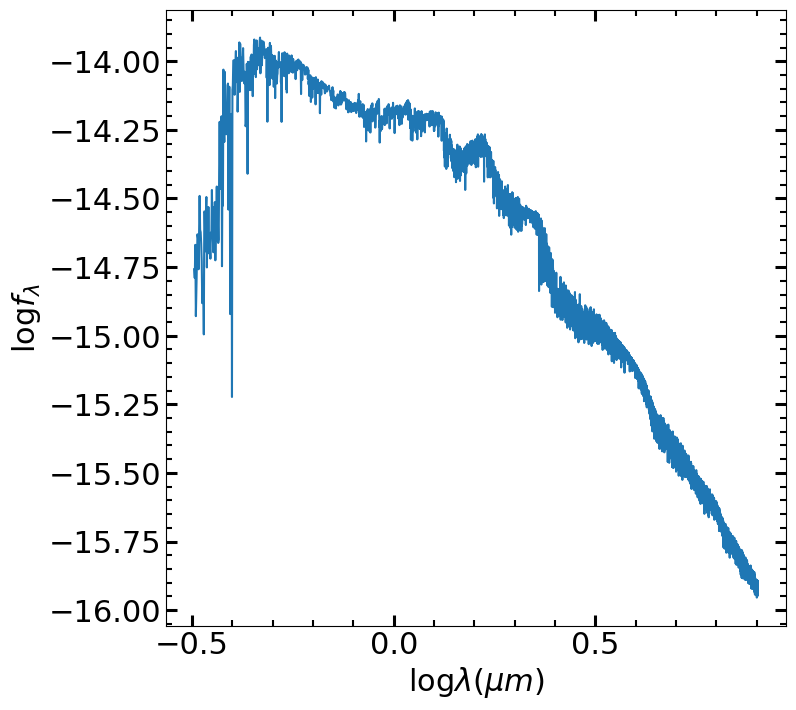

In [206]:
fig = plt.figure(figsize = (8, 8))
plt.plot(np.log10(wav1 * (1e-4)), np.log10(flux1[40]))
plt.ylabel('log' +  f'$f_\lambda$')
plt.xlabel('log' +  f'$\lambda (\mu m)$')
plt.minorticks_on()
plt.tick_params(which = 'major', right = True, top = True, direction = 'in', width = 2.2, length = 8)
plt.tick_params(which = 'minor', right = True, top = True, direction = 'in', width = 1.5, length = 4)
plt.show()

Finally, alot of times SED's are presented in wavelength * flux vs wavelength so here is an example of how one might do that. the resulting data is in erg/cm^2/s

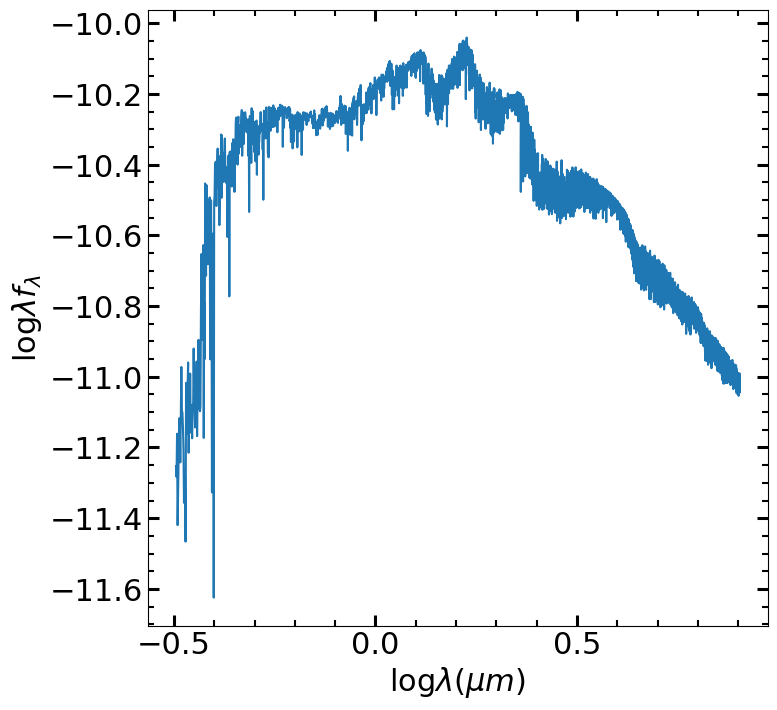

In [207]:
fig = plt.figure(figsize = (8, 8))
plt.plot(np.log10(wav1 * (1e-4)), np.log10(wav1 * flux1[40]))
plt.ylabel('log' +  f'$\lambda f_\lambda$')
plt.xlabel('log' +  f'$\lambda (\mu m)$')
plt.minorticks_on()
plt.tick_params(which = 'major', right = True, top = True, direction = 'in', width = 2.2, length = 8)
plt.tick_params(which = 'minor', right = True, top = True, direction = 'in', width = 1.5, length = 4)
plt.show()

## SED of a Star

For a more in depth model we will want to add in a star as well. in order to get spectral data for the star we used the SVO Stellar Spectra Models that can be found here http://svo2.cab.inta-csic.es/theory/newov2/index.php. Specifically we used the BtSettle and bt-nextgen models for low and high temps respectively.

This function reads in resampled spectra. This spectra has been resampled in order to match the range of wavelengths I used for the disk model, but can be resampled for other wavelength ranges using the stellar_resampling function. The primary reason this is done is that each of the original temperature files had something like 48,000 datapoints which is too high detail for what we were doing.

in any case, stellar_spec is used to obtain the luminosity of the star when given a specific temperature (ie 5000k), a reference folder where the stellar spectra are stored (in case you decide to resample to data and assign the new data to a new folder), and allows you to choose a radius for the star (in this case I did the radius of the Sun in cm)

In [208]:
def stellar_spec(Temp, folder_name = 'Stellar Spectra', R = 6.96E10):
    dumpfile = base + folder_name + '/Modelspec' + str(Temp) + '.txt'
    dump = np.loadtxt(dumpfile, unpack=True, delimiter = ' ')
    wav = dump[0]  #Angstrom
    flux = dump[1] #erg/cm^2/s/A

    L = 4* np.pi* (R**2) *flux #erg/cm^2/s/A to erg/s/A
    return wav, L

The below two functions are used in the resampling process if necessary. The function temp is given a star temperature and finds the corresponding spectra file, and stellar_resampling does the actual resampling using the Spectres function (more info on spectres can be found here: https://spectres.readthedocs.io/en/latest/ ). All that is need to resample to data is to provide a folder for the files to save to and to give it the wavelength range to resample to using the regrid variable. the files can be saved to an already existing folder or to a new one. If a folder name is given and there is no existing path for it then the function will make a new folder with that name

In [209]:
def temp(Temp):
  if Temp >= 100:
    dumpfile = base + 'bt-nextgen-agss2009/lte' + str(int(Temp)) + '-1.0-0.0a+0.0.BT-NextGen.7.dat.txt'
  elif 100 > Temp >= 30:
    dumpfile = base + 'bt-nextgen-agss2009/lte0' + str(int(Temp)) + '-1.0-0.0a+0.0.BT-NextGen.7.dat.txt'
  elif 30 > Temp >= 26:
    dumpfile = base + 'BtSettl low temperature/lte0' + str(int(Temp)) + '-1.0-0.0a+0.0.BT-Settl.7.dat.txt'
  elif 26 > Temp >= 20:
    dumpfile = base + 'BtSettl low temperature/lte0' + str(int(Temp)) + '-1.0-0.0.BT-Settl.7.dat.txt'
  else:
    dumpfile = base + 'BtSettl low temperature/lte0' + str(int(Temp)) + '-3.5-0.0.BT-Settl.7.dat.txt'
  dump = np.loadtxt(dumpfile, unpack=True)
  wav = dump[0]  #Ang
  flux = dump[1] #erg/cm^2/s/Ang
  return wav, flux

In [210]:
def stellar_resampling(folder_name, regrid):
  #the stellar spectra files are spaced in changing intervals to its necessary to create the list as so
  num1 = np.arange(14,71,1).tolist() + np.arange(72, 121, 2).tolist() + np.arange(125, 151, 5).tolist()

  #this bit is used to determine if the folder you want to assign the resampled files to exists. If it doesnt then it will create one
  path = base + folder_name
  path_test = os.path.exists(path)
  if path_test == False:
    os.mkdir(path)

  for i in num1:
    model_wavs, model_grid = temp(i)
    model_resampled = spectres(regrid, model_wavs, model_grid)
    total = [model_resampled, regrid]
    i = i * 100
    np.savetxt(path + '/Modelspec' + str(i) + '.txt', np.rot90(np.array(total), k = 3), header = 'column 1 is wavelength in Angstroms and column 2 is wavelength flux in (erg/cm^2/s/A)')


In [211]:
#this is how the function would be used if you did want to resample the data.
#stellar_resampling(folder_name = 'Stellar Spectra', regrid =  = np.arange(3.20e3, 8.001e4, 10))

Now we can load in the resampled stellar spectra and plot in the same way we did for the disk. I am only going to show it plotted using original luminosity because the method is the same to convert to flux or wavelength * flux as shown above.

In [212]:
wav2, lum2 = stellar_spec(5000)

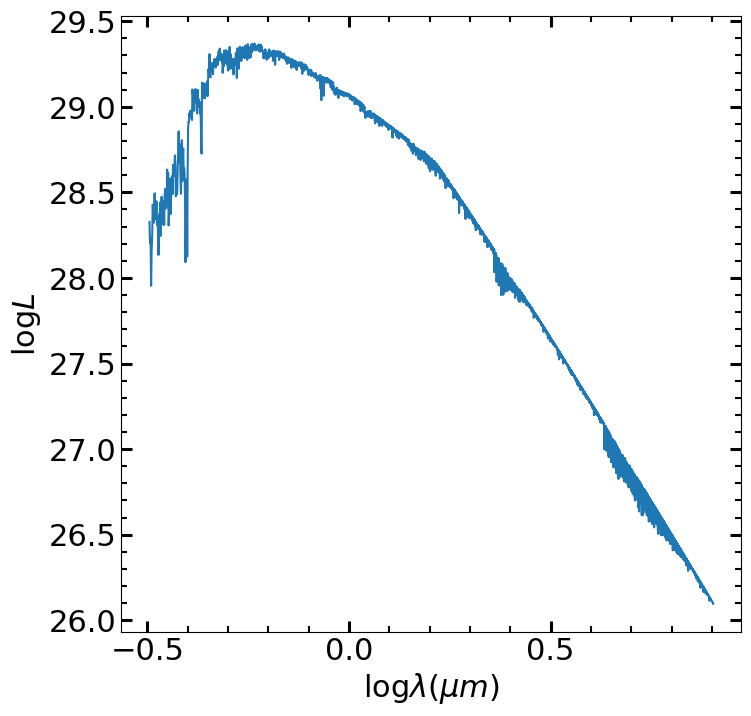

In [213]:
fig = plt.figure(figsize = (8, 8))
plt.plot(np.log10(wav2 * (1e-4)), np.log10(lum2))
plt.ylabel('log' +  f'$L$')
plt.xlabel('log' +  f'$\lambda (\mu m)$')
plt.minorticks_on()
plt.tick_params(which = 'major', right = True, top = True, direction = 'in', width = 2.2, length = 8)
plt.tick_params(which = 'minor', right = True, top = True, direction = 'in', width = 1.5, length = 4)
plt.show()

## Adding a Star and/or Extinction Into the Model

Now this is the part thats a little cooler. We know how to create a star and a disk so to combine the two we simply add their total spectra. The below function lets you do this for a star of any given radius or temperature. Additionally the function lets you input extinction into the model using the PyAstronomy unred function (we actually want to redden the data by placing extinction in instead of removing extinction so we use a negative ebv value) the docs for PyAstronomy unred can be found here: https://pyastronomy.readthedocs.io/en/latest/pyaslDoc/aslDoc/unredDoc.html

The function automatically assumes you want a star and extinction added in, but can be used in a similar manner as the flux() function if both extinction and star are set to False.

In [214]:
def star_ext_adder(wav, lum, distance = kpc, cosi = .5, extinction = True, star = True, temp = 5000, ebv=-1.13548387, R_V=3.1, folder_name = 'Stellar Spectra', R = 6.96E10):
  #adding star and disk spectra if star is True
  if star == True:
    starwav, starlum = stellar_spec(temp, folder_name, R)
    for i in range(len(lum)):
      lum[i] = lum[i] + starlum

  #adding extinction in if extinction = True using unred
  if extinction == True:
    f_hill = (1e7) * flux(lum, distance, cosi) #convert flux into W/m^2/m for pysal reddening function
    fluxred = pyasl.unred(np.array(wav), f_hill, ebv, R_V) #W/m^2/m
    fluxred = fluxred * (1E-7) #erg/cm^2/s/A
    return fluxred

  #if extinction = False we just return the flux of lum
  elif extinction == False:
    return flux(lum, distance, cosi)

We can now try adding in the star and extinction using one of the disk models (in this case mar.1.1 which has 93 timesteps)

In [215]:
wav3, lum3 = load_lum('mar.1.1')
print(len(lum3))

93


We will start with no extinction or star and plot the result (should be very similar to what was previously done in the first section)

In [216]:
flux_no_star_no_extinction = star_ext_adder(wav3, lum3, extinction = False, star = False)

#alternatively you also could have used our original flux function to get same result: flux_no_star_no_extinction = flux(lum3)

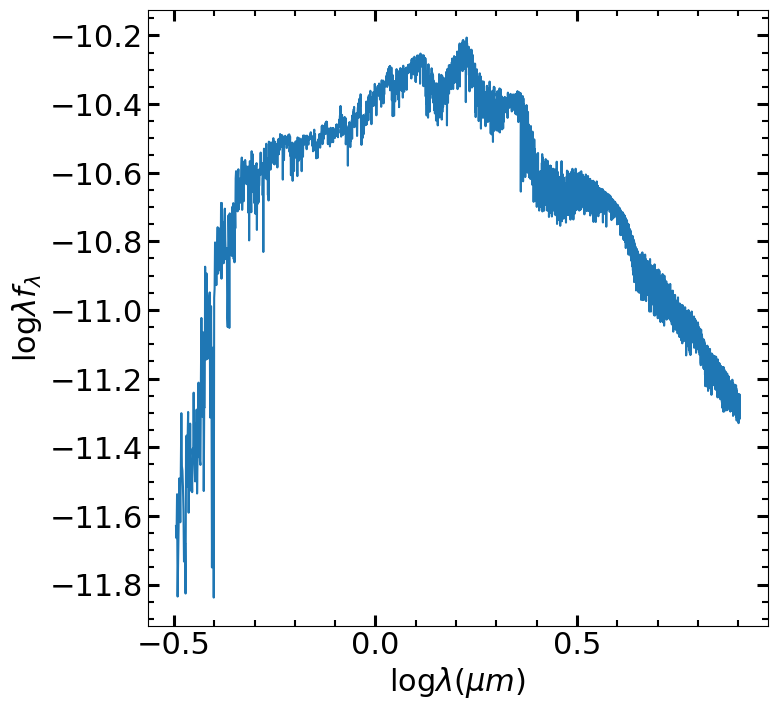

In [217]:
fig = plt.figure(figsize = (8, 8))
plt.plot(np.log10(wav3 * (1e-4)), np.log10(wav3 * flux_no_star_no_extinction[10]))
plt.ylabel('log' +  f'$\lambda f_\lambda$')
plt.xlabel('log' +  f'$\lambda (\mu m)$')
plt.minorticks_on()
plt.tick_params(which = 'major', right = True, top = True, direction = 'in', width = 2.2, length = 8)
plt.tick_params(which = 'minor', right = True, top = True, direction = 'in', width = 1.5, length = 4)
plt.show()

Now we can try it with a star added but no extinction added

In [218]:
flux_star_no_extinction = star_ext_adder(wav3, lum3, extinction = False, star = True)

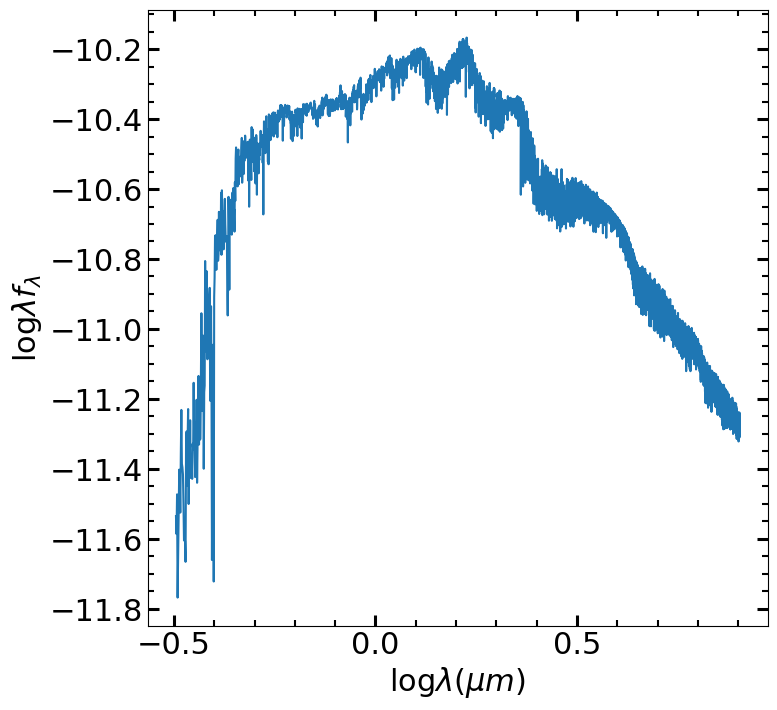

In [219]:
fig = plt.figure(figsize = (8, 8))
plt.plot(np.log10(wav3 * (1e-4)), np.log10(wav3 * flux_star_no_extinction[10]))
plt.ylabel('log' +  f'$\lambda f_\lambda$')
plt.xlabel('log' +  f'$\lambda (\mu m)$')
plt.minorticks_on()
plt.tick_params(which = 'major', right = True, top = True, direction = 'in', width = 2.2, length = 8)
plt.tick_params(which = 'minor', right = True, top = True, direction = 'in', width = 1.5, length = 4)
plt.show()

You might notice that it doesnt look very different. That is because the disk has nearly reached the peak of the outburst at the time stamp plotted. At this point in the outburst evolution the disk will outshine its host star and thus the stars spectra will have a very small impact on the overall SED.

for an example of the disks rise is emission you can look below at time steps 2, 4, and 6. at time step 2 the spectra is almost all the stars and it looks very similar to when we plotted the star by itself with some disk emission beyond log(lambda) of .4. However, by step 4 we can see that the disk is starting to emit more at longer wavelengths. By step 6, the disk is getting hotter and hotter and the resulting disk spectra is becoming stronger at the lower more energetic wavelengths

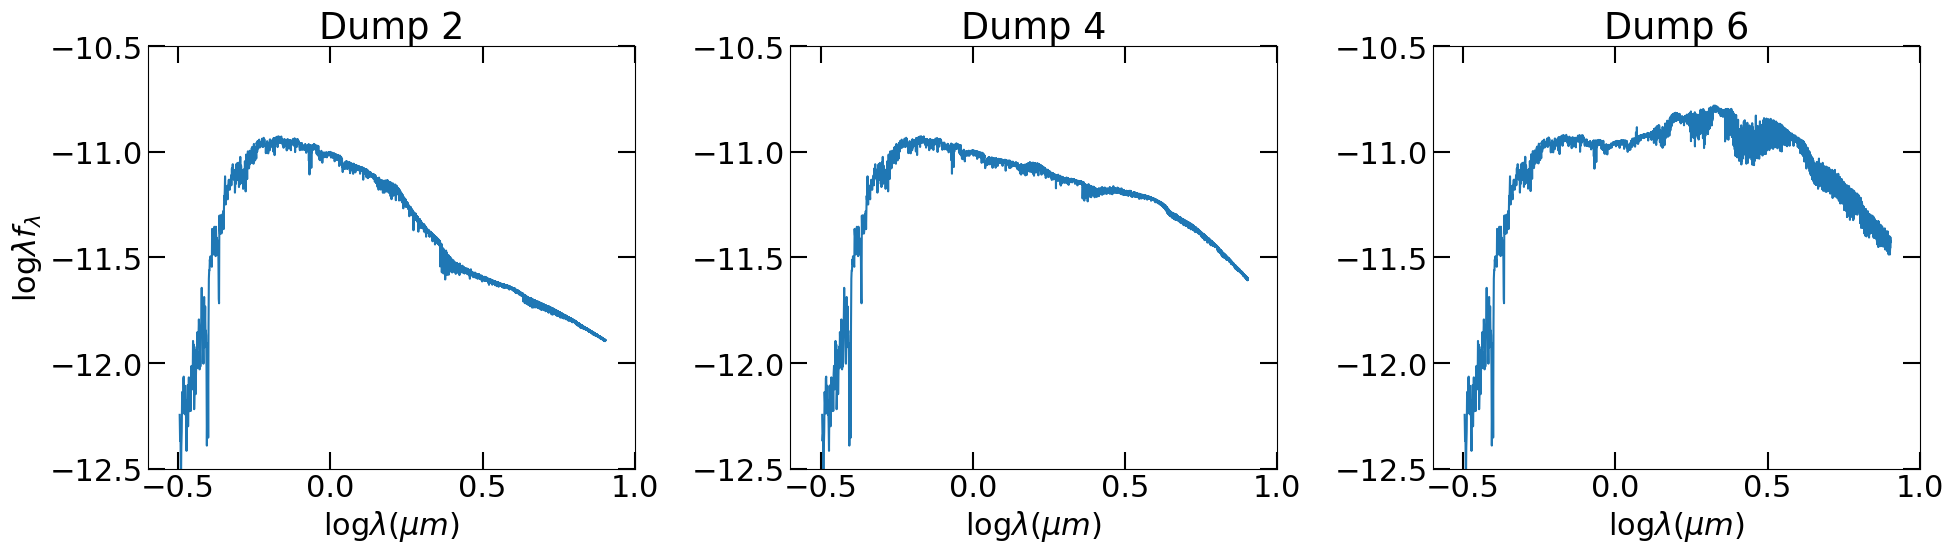

In [220]:
axe = [-.6,1,-12.5,-10.5]
fig, ax = plt.subplots(1, 3, figsize=(20, 6))
#fig.suptitle('Temperature vs Radii')
plt.rc('font', size=22)

#ax[0][0].set_title('Initial')
ax[0].plot(np.log10(wav3 * (1e-4)), np.log10(wav3 * flux_star_no_extinction[2]))
ax[0].set_title('Dump 2')
ax[0].set_xlabel('log' +  f'$\lambda (\mu m)$')
ax[0].set_ylabel('log' +  f'$\lambda f_\lambda$',rotation=90)
ax[0].axis(axe)
ax[0].tick_params(which = 'major', right = True, top = True, direction = 'in', width = 1.5, length = 12)
ax[0].tick_params(which = 'minor', right = True, top = True, direction = 'in', width = 1.5, length = 7)

ax[1].plot(np.log10(wav3 * (1e-4)), np.log10(wav3 * flux_star_no_extinction[4]))
ax[1].set_title('Dump 4')
ax[1].set_xlabel('log' +  f'$\lambda (\mu m)$')
ax[1].axis(axe)
ax[1].tick_params(which = 'major', right = True, top = True, direction = 'in', width = 1.5, length = 12)
ax[1].tick_params(which = 'minor', right = True, top = True, direction = 'in', width = 1.5, length = 7)

ax[2].plot(np.log10(wav3 * (1e-4)), np.log10(wav3 * flux_star_no_extinction[6]))
ax[2].set_title('Dump 6')
ax[2].set_xlabel('log' +  f'$\lambda (\mu m)$')
ax[2].axis(axe)
ax[2].tick_params(which = 'major', right = True, top = True, direction = 'in', width = 1.5, length = 12)
ax[2].tick_params(which = 'minor', right = True, top = True, direction = 'in', width = 1.5, length = 7)

fig.tight_layout()
plt.show()
fig.savefig('/content/drive/MyDrive/outburst/Images/dec82_sigmas_v3.eps')
plt.close()

Finally we can try it with both a star and extinction added into the model. You can see that the SED is signifigantly dimmer as caused by the addition of the extinction (this is much more prominent at the lower wavelengths).

In [221]:
flux_star_extinction = star_ext_adder(wav3, lum3, extinction = True, star = True)

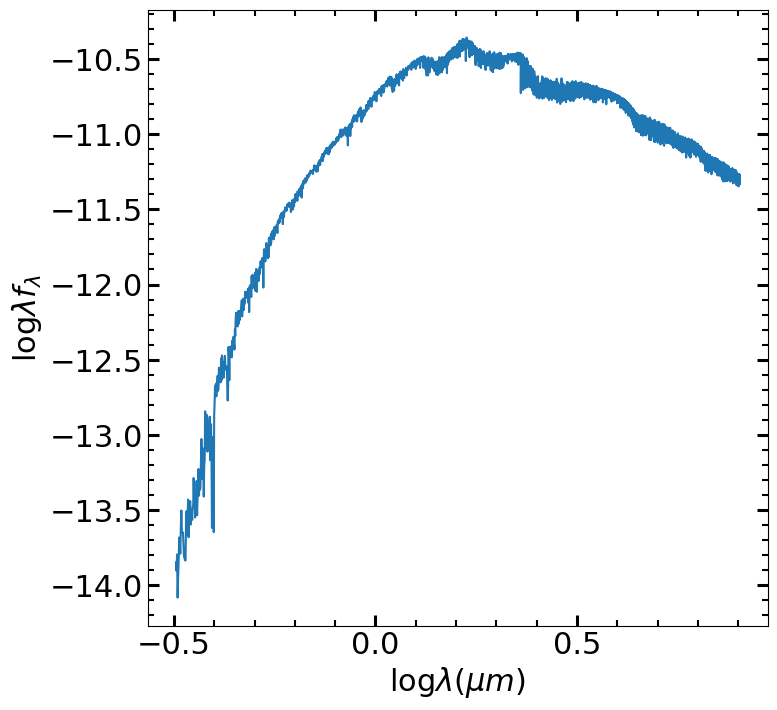

In [222]:
fig = plt.figure(figsize = (8, 8))
plt.plot(np.log10(wav3 * (1e-4)), np.log10(wav3 * flux_star_extinction[10]))
plt.ylabel('log' +  f'$\lambda f_\lambda$')
plt.xlabel('log' +  f'$\lambda (\mu m)$')
plt.minorticks_on()
plt.tick_params(which = 'major', right = True, top = True, direction = 'in', width = 2.2, length = 8)
plt.tick_params(which = 'minor', right = True, top = True, direction = 'in', width = 1.5, length = 4)
plt.show()

Here is a combined plot showing all three examples and how the addition of a star and/or extinction impacts the model

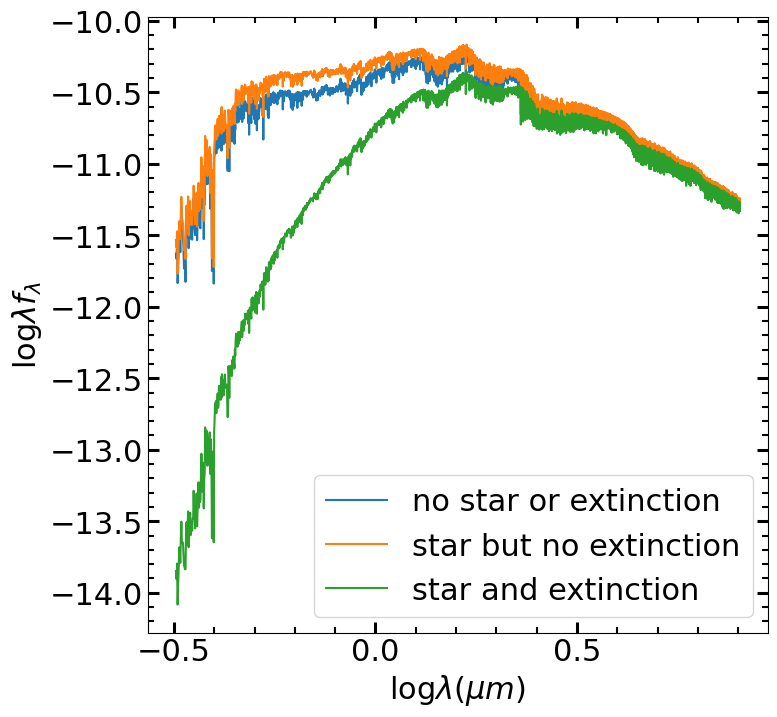

In [223]:
fig = plt.figure(figsize = (8, 8))
plt.plot(np.log10(wav3 * (1e-4)), np.log10(wav3 * flux_no_star_no_extinction[10]), label = 'no star or extinction')
plt.plot(np.log10(wav3 * (1e-4)), np.log10(wav3 * flux_star_no_extinction[10]), label = 'star but no extinction')
plt.plot(np.log10(wav3 * (1e-4)), np.log10(wav3 * flux_star_extinction[10]), label = 'star and extinction')
plt.ylabel('log' +  f'$\lambda f_\lambda$')
plt.xlabel('log' +  f'$\lambda (\mu m)$')
plt.minorticks_on()
plt.legend()
plt.tick_params(which = 'major', right = True, top = True, direction = 'in', width = 2.2, length = 8)
plt.tick_params(which = 'minor', right = True, top = True, direction = 'in', width = 1.5, length = 4)
plt.show()

## Thats All Folks!

I hope that you found this all useful. If you have any further questions please reach out to me at cleaverj@umich.edu. I would be more than happy to help.

Feel free to edit any of these functions. I have my own copy saved so this is all yours to experiment with and change as needed.

Hope you enjoy your work with prof. Hartmann and I look forward to seeing what may come of this research!